# Library

In [89]:
#library
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import scipy
from scipy import stats
from scipy.integrate import solve_ivp
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats import shapiro
from scipy.stats import wilcoxon
import time
from tqdm import tqdm
import seaborn as sns

np.random.seed(123)  # For reproducibility

# Parameters


In [62]:
'''
PARAMETERS
'''

#define parameters
n_species = 4
n_cs = 10 # cs = carbon sources

#default values
g = np.ones(n_species) # conversion factor from energy uptake to growth rate, for species i ## all 1's, so all the energy is converted into growth ?
m = np.zeros(n_species) # minimal energy uptake for maintenance of species (energy/time)
l = 0.1*np.ones((n_species, n_cs)) # leakage fractions for resource 'a' (unitless)
K = 1e-1*np.ones(n_cs) # consider making this small (affinity)
w = np.ones(n_cs) # all metabolites have the same energy
d = 0.1 # dilution rate
c =  np.ones((n_species,n_cs)) #MAX uptake of a ressource a by a species i
J = np.zeros((n_species, n_cs)) #energie intake d'in individu i par une ressource a
D = np.full((n_species, n_cs, n_cs),0.05) #matrice du by product d'une ressource b produit par un individu i consommant une ressource a

print(c)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [63]:
N0 = [ # list of initial population densities
    1e-4, # species 1
    1e-4, # species 2
    1e-4, # species   # species 4
    ]
R0 = np.zeros(n_cs) # concentration of resources at t=0 (mass/volume)
R0[0] = 10 # first resource has a concentration of 10 (why ?) parce que après on va peut être obtenir les autres ressources grace aux byproduct
y0 = np.append(np.array(N0),R0)

In [72]:
'''
DETAILED AND RANDOMIZED PARAMETERS
- w = 1, m = 0, l=0, d=0
'''

# INITAL POPULATION
n_species = 3
N0 = np.array([1e-1, 1e-2, 5e-2]) # species 1,2,3

# INITAL RESOURCES
n_cs = 3 # cs = carbon sources
R0 = np.array([10, 0, 0]) # resources 1,2,3

# INITIAL STATE
y0 = np.append(np.array(N0),R0)

# ----------------------------
'''
# CONVERSION FACTOR from energy to growth rate (DETAILED)
g = np.ones(n_species)
g = np.array([0.25, 0.5, 0.5]) # for species 1,2,3
'''

# CONVERSION FACTOR from energy to growth rate (RANDOM)
g = np.ones(n_species)
for i in range(n_species):
    g[i] = np.random.rand()

# ----------------------------
# AFFINITY of each resource
K = np.ones(n_cs)
K = np.array([0.01, 0.02, 0.01]) # for resource 1,2,3

# ----------------------------
'''
# MAX UPTAKE of a resource a by a species i (DETAILED)
c =  np.ones((n_species,n_cs)) # MAX UPTAKE of a ressource a by a species i
c = np.array([[0.8, 0.5, 1.0],  # species 1, resource 1,2,3
              [1.0, 0.8, 0.5],  # species 2, resource 1,2,3
              [0.5, 1.0, 0.8]]) # species 3, resource 1,2,3
'''

# MAX UPTAKE of a resource a by a species i (RANDOM)
c =  np.ones((n_species,n_cs)) # MAX UPTAKE of a ressource a by a species i
for i in range(n_species) :
  for j in range(n_cs):
    c[i, j] = np.random.rand()  # Randomize c for each species and resource

# ----------------------------
# BYPRODUCT produced by species a from resource i (RANDOM)
D = np.zeros((n_species, n_cs, n_cs))
for i in range(n_species):
    for b in range(n_cs):
        random_values = np.random.rand(n_cs)
        normalized_values = random_values / np.sum(random_values)  # Normalize to ensure the sum is 1
        D[i, :, b] = normalized_values * np.random.rand()  # Randomize the scaling to ensure the sum is less than 1

'''
# BYPRODUCT produced by species a from resource i (DETAILED)
D = np.zeros((n_species, n_cs, n_cs))

# Production by species 1
D[0] = [
    [0.05, 0, 0],   # byproduct 1 from resources 1, 2, 3
    [0, 0.075, 0],  # byproduct 2 from resources 1, 2, 3
    [0, 0, 0.1]     # byproduct 3 from resources 1, 2, 3
]
# Production by species 2
D[1] = [
    [0.125, 0, 0],  # byproduct 1 from resources 1, 2, 3
    [0, 0.15, 0],   # byproduct 2 from resources 1, 2, 3
    [0, 0, 0.175]   # byproduct 3 from resources 1, 2, 3
]
# Production by species 3
D[2] = [
    [0.2, 0, 0],    # byproduct 1 from resources 1, 2, 3
    [0, 0.225, 0],  # byproduct 2 from resources 1, 2, 3
    [0, 0, 0.25]    # byproduct 3 from resources 1, 2, 3
]
'''

# ----------------------------
# DILUTION RATE (=decay)
d = 0.1

# Complete model


In [65]:
'''
MODEL 1 : CR_model
'''

# complete model
def CR_model(t, y):

  N = y[:n_species]
  R = y[n_species:]
  R[R<0] = 0 #no negative values
  N[N<1e-6] = 0 #no negative values
  J = np.zeros((n_species, n_cs)) # uptake of resource i by species a
  for i in range(n_species): # for every resource
    for a in range(n_cs): # for every species
      J[i,a] = c[i,a]*R[a]/(R[a]+K[a]) # uptake ~ max uptake, resource concentration, affinity

  dNdt = np.zeros(n_species) # variation in population ~ resource uptake
  for i in range(n_species): # for every species
    growth_intake = np.sum([(J[i, a]*w[a]*(1-l[i,a]))-m[i]for a in range(n_cs)]) # growth ~ uptake, energy content of resource, leakage, maintenance
                                                                                 # -> sum of every resource
    dNdt[i] = g[i]*N[i]*growth_intake-(N[i]*d) # population evolution ~ conversion rate, population, growth intake, dilution rate

  dRdt = np.zeros(n_cs) # variation in resource ~ consumption and byproduct production
  for a in range(n_cs): # for every resource
    consumption = np.sum([N[i]*J[i,a] for i in range(n_species)]) # consumption ~ population, resource uptake
                                                                  # -> sum for every species
    byproduction_tot = np.zeros((n_species, n_cs)) # byproduct production
    for i in range(n_species): # for every species
      for b in range(n_cs): # for every resource
        byproduction_tot[i,b] = D[i,a,b]*w[b]*l[i,b]*N[i]*J[i,b]/w[a] # production ~ fraction converted, energy content, leakage, population, uptake
    byproduction = np.sum(byproduction_tot) # add all byproduct production FOR ONE RESOURCE (see [24])
    dRdt[a] = (R0[a]-R[a])*d - consumption + byproduction # resource evolution ~ dilution, consumption, byproduct production

  return np.concatenate((dNdt,dRdt))

In [66]:
t_span = (0,100)
t_eval = np.linspace(t_span[0], t_span[1],300)

In [41]:
#solution of the model
c[0,0] = 0.5
c[1,0] = 0.75
c[2,0] = 0
c[3,1] = 0
c[1,1] = 0
c[2,1] = 0.2
c[0,1] = 0.2
c[0,2] = 0.1
c[1,2] = 0
c[2,2] = 0.6
c[3,2] = 0
c[0,3] = 0
c[1,3] = 0.2
c[2,3] = 0
c[3,3] = 0
print(c)

solutions = solve_ivp(CR_model, t_span, y0, args=(c, K, w, l, m, g, d, D), method = "BDF")

[[0.5  0.2  0.1  0.   1.   1.   1.   1.   1.   1.  ]
 [0.75 0.   0.   0.2  1.   1.   1.   1.   1.   1.  ]
 [0.   0.2  0.6  0.   1.   1.   1.   1.   1.   1.  ]
 [1.   0.   0.   0.   1.   1.   1.   1.   1.   1.  ]]


TypeError: CR_model() takes 2 positional arguments but 10 were given

NameError: name 'solutions' is not defined

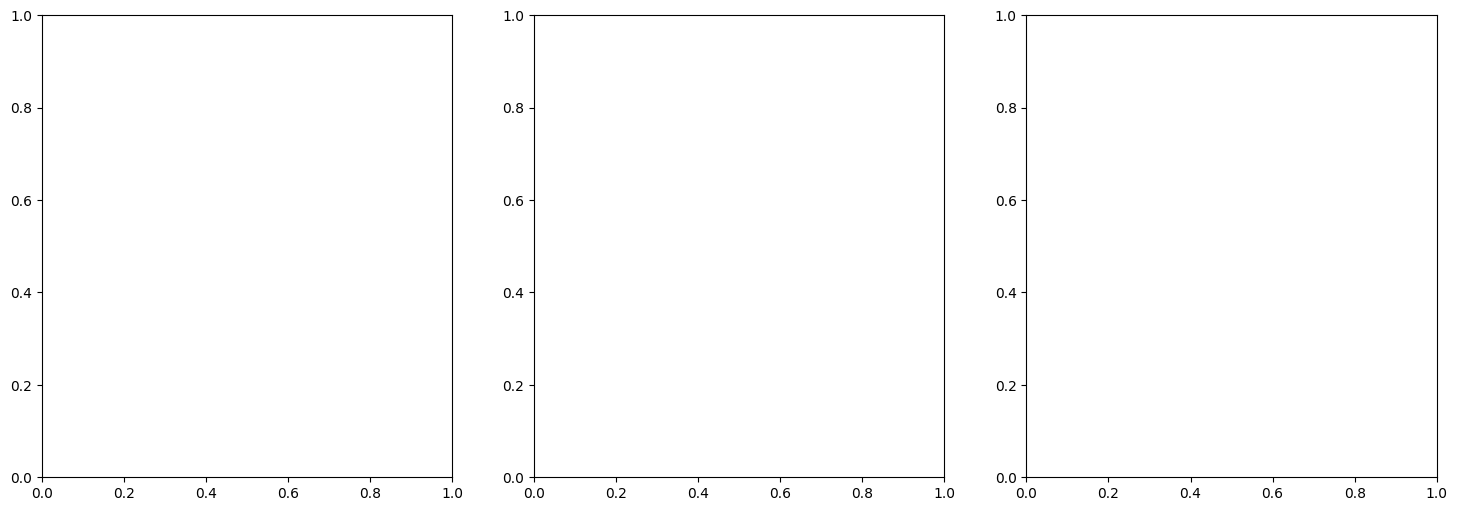

In [67]:
# better plot for solutions ?

legend_species = [f"Species {i}" for i in range(1, n_species+1)]
legend_cs = [f"Resource {i}" for i in range (1, n_cs+1)]

cmap_species = cm.viridis
colors_species = [cmap_species(i / n_species) for i in range(n_species)]

cmap_cs = cm.inferno
colors_cs = [cmap_cs(i / n_cs) for i in range(n_cs)]


fig, axs = plt.subplots(1,3, figsize=(18, 6))

# Premier graphique avec tout
for i in range(n_species):
    axs[0].plot(solutions.t,
                solutions.y[i],
                label=legend_species[i],
                color=colors_species[i],
                linewidth=2.0)
for i in range(n_cs):
    axs[0].plot(solutions.t,
                solutions.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[0].set_yscale('log')
axs[0].set_title('All Species and Resources')

# Deuxième graphique avec seulement les espèces
for i in range(n_species):
    axs[1].plot(solutions.t,
                solutions.y[i],
                label=legend_species[i],
                color=colors_species[i])
axs[1].set_yscale('log')
axs[1].set_title('Species evolution')

# Troisième graphique avec seulement les cs
for i in range(n_cs):
    axs[2].plot(solutions.t,
                solutions.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[2].set_yscale('log')
axs[2].set_title('Resource concentration evolution')

# Titres et légendes
for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Population / Concentration')
    ax.legend(loc='upper center',
              bbox_to_anchor=(0.5, -0.15),
              fancybox=True,
              shadow=True,
              ncol=3)

plt.tight_layout()
plt.show()

In [68]:
#Randomisation of some parameters
#c = np.random.uniform(low = 0, high = 1,size = (n_species,n_cs))
D = np.random.uniform(low = 0, high = 0.1,size=(n_species, n_cs, n_cs)) #matrice du by product d'une ressource b produit par un individu i consommant une ressource a)


In [73]:
t_span = (0,10000)
t_eval = np.linspace(t_span[0], t_span[1],300)
solutions2 = solve_ivp(CR_model, t_span, y0, method = "BDF")

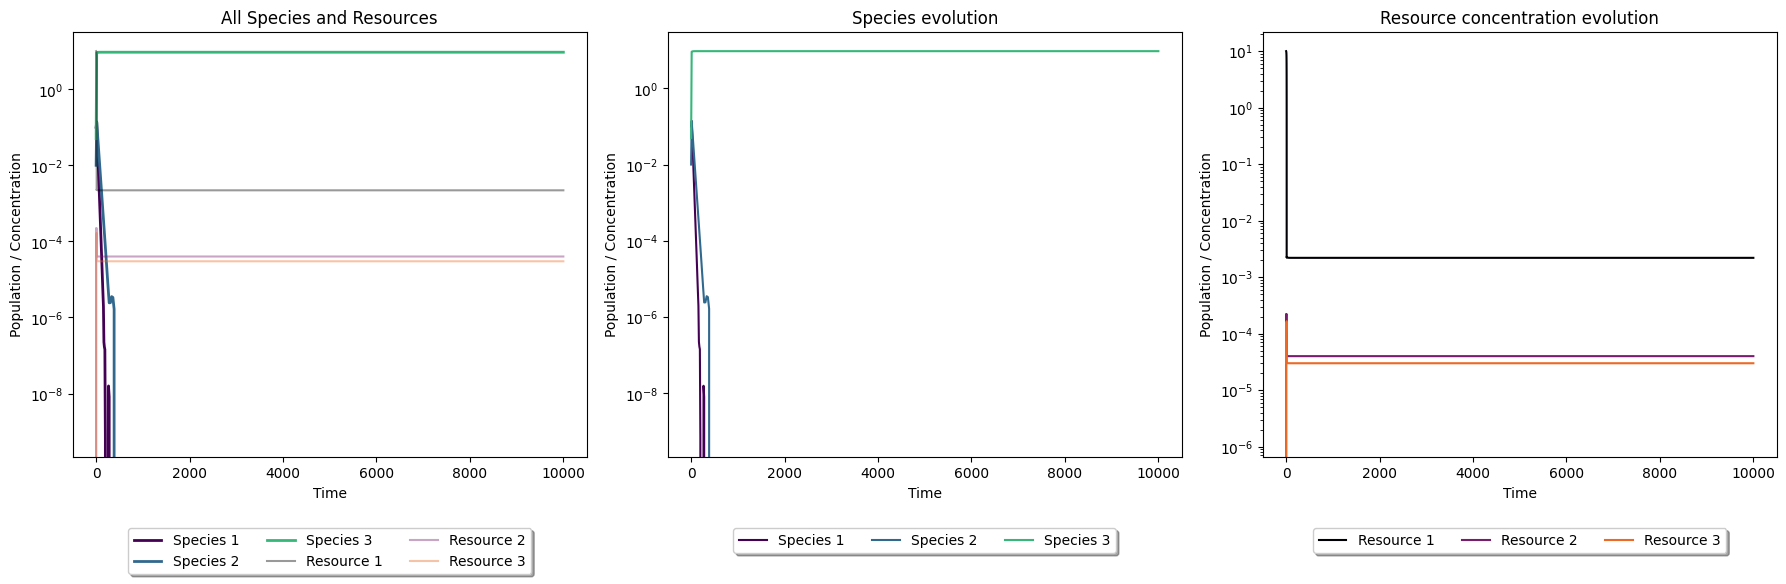

In [74]:
# better plot for solutions *2* ?

legend_species = [f"Species {i}" for i in range(1, n_species+1)]
legend_cs = [f"Resource {i}" for i in range (1, n_cs+1)]

cmap_species = cm.viridis
colors_species = [cmap_species(i / n_species) for i in range(n_species)]

cmap_cs = cm.inferno
colors_cs = [cmap_cs(i / n_cs) for i in range(n_cs)]


fig, axs = plt.subplots(1,3, figsize=(18, 6))

# Premier graphique avec tout
for i in range(n_species):
    axs[0].plot(solutions2.t,
                solutions2.y[i],
                label=legend_species[i],
                color=colors_species[i],
                linewidth=2.0)
for i in range(n_cs):
    axs[0].plot(solutions2.t,
                solutions2.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i],
                alpha = 0.4)
axs[0].set_yscale('log')
axs[0].set_title('All Species and Resources')

# Deuxième graphique avec seulement les espèces
for i in range(n_species):
    axs[1].plot(solutions2.t,
                solutions2.y[i],
                label=legend_species[i],
                color=colors_species[i])
axs[1].set_yscale('log')
axs[1].set_title('Species evolution')

# Troisième graphique avec seulement les cs
for i in range(n_cs):
    axs[2].plot(solutions2.t,
                solutions2.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[2].set_yscale('log')
axs[2].set_title('Resource concentration evolution')

# Titres et légendes
for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Population / Concentration')
    ax.legend(loc='upper center',
              bbox_to_anchor=(0.5, -0.15),
              fancybox=True,
              shadow=True,
              ncol=3)

plt.tight_layout()
plt.show()

In [ ]:
#random multiple simulations
t_span = (0,100000)
t_eval = np.linspace(t_span[0], t_span[1],300)
sim_dict = {}
for i in range(20):
  c = np.random.uniform(low = 0, high = 1,size = (n_species,n_cs))
  D = np.random.uniform(low = 0, high = 0.1,size=(n_species, n_cs, n_cs))
  sol = solve_ivp(CR_model, t_span, y0,args=(c, K, w, l, m, g, d, D), method = "BDF")
  sim_dict[f"simulation {i}"] = [[c,D],sol]


In [ ]:
#plotting usinage
#trash

fig, axs = plt.subplots(4,5,figsize = (20,10))

for ax, key, value in zip(axs.ravel(), sim_dict.keys(), sim_dict.values()):
  ax.plot(value[1].t, value[1].y[0], label='Species 1')
  ax.plot(value[1].t, value[1].y[1], label='Species 2')
  ax.plot(value[1].t, value[1].y[2], label='Species 3')
  ax.plot(value[1].t, value[1].y[3], label='Species 4')  #ax.set_yscale("log")
plt.tight_layout()
plt.show()


# Simple model

In [25]:
# MODEL
def CR_model_simple(t,y) :

  N = y[:n_species]
  R = y[n_species:]
  R[R<0] = 0 #no negative values
  N[N<1e-6] = 0 #no negative values

  # resource uptake
  J = np.zeros((n_species, n_cs)) # uptake of resource i by species a
  for i in range(n_species): # for every resource
    for a in range(n_cs): # for every species
      J[i, a] = c[i, a] * R[a] / (R[a] + K[a]) # uptake ~ max uptake, resource concentration, affinity

 # population variation
  dNdt = np.zeros(n_species) # variation in population ~ resource uptake
  for i in range(n_species): # for every species
    growth_intake = np.sum(J[i, :]) # growth ~ uptake, energy content of resource // NO LEAKAGE, NO MAINTENANCE                                                                             # -> for every resource, added up
    dNdt[i] = g[i]*N[i]*growth_intake-(N[i]*d) # population evolution ~ conversion rate, population, growth intake // with dilution (else population will never decrease and we won't be able to determine in wich case it doesn't)

  # resource variation
  dRdt = np.zeros(n_cs) # variation in resource ~ consumption and byproduct production
  for a in range(n_cs): # for every resource
    consumption = np.sum([N[i]*J[i,a] for i in range(n_species)]) # consumption ~ population, resource uptake

    # byproduct formation                                                                 # -> sum for every species
    byproduction_tot = np.zeros((n_species, n_cs)) # byproduct production
    for i in range(n_species): # for every species
      for b in range(n_cs): # for every resource
        byproduction_tot[i, b] = D[i, a, b] * N[i] * J[i, b] # production ~ fraction converted, energy content, population, uptake // NO LEAKAGE, NO VAR IN RESOURCE ENERGY CONTENT
    byproduction = np.sum(byproduction_tot[:, a]) # add all byproduct production FOR ONE RESOURCE (see [24])
    dRdt[a] = (R0[a]-R[a]) - consumption + byproduction # resource evolution ~ consumption, byproduct production // NO DILUTION

  return np.concatenate((dNdt,dRdt))

In [ ]:
# DEFINE TIMEFRAME, SEARCH SOLUTIONS
t_span = (0,500)
solutions_simple = solve_ivp(CR_model_simple, t_span, y0, method = "BDF")


# PLOT SOLUTIONS
legend_species = [f"Species {i}" for i in range(1, n_species+1)]
legend_cs = [f"Resource {i}" for i in range (1, n_cs+1)]

cmap_species = cm.viridis
colors_species = [cmap_species(i / n_species) for i in range(n_species)]

cmap_cs = cm.inferno
colors_cs = [cmap_cs(i / n_cs) for i in range(n_cs)]


fig, axs = plt.subplots(1,3, figsize=(18, 6))

# Premier graphique avec tout
for i in range(n_species):
    axs[0].plot(solutions_simple.t,
                solutions_simple.y[i],
                label=legend_species[i],
                color=colors_species[i],
                linewidth=2.0)
for i in range(n_cs):
    axs[0].plot(solutions_simple.t,
                solutions_simple.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i],
                alpha = 0.4)
axs[0].set_yscale('log')
axs[0].set_title('All Species and Resources')

# Deuxième graphique avec seulement les espèces
for i in range(n_species):
    axs[1].plot(solutions_simple.t,
                solutions_simple.y[i],
                label=legend_species[i],
                color=colors_species[i])
axs[1].set_yscale('log')
axs[1].set_title('Species evolution')

# Troisième graphique avec seulement les cs
for i in range(n_cs):
    axs[2].plot(solutions_simple.t,
                solutions_simple.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[2].set_yscale('log')
axs[2].set_title('Resource concentration evolution')

# Titres et légendes
for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Population / Concentration')
    ax.legend(loc='upper center',
              bbox_to_anchor=(0.5, -0.15),
              fancybox=True,
              shadow=True,
              ncol=3)
    ax.set_ylim(bottom=1e-6) # anything below is considered absent


plt.tight_layout()
plt.show()
f2 = solutions_simple.y[1][-1:]
f3 = solutions_simple.y[2][-1:]

# Interactive plots

In [37]:
'''
TEST plotly
'''
'''
# Résolution du modèle
t_span = (0, 1000)
solution = solve_ivp(
    lambda t, y: CR_model(t, y),
    t_span,
    y0,
    method = 'BDF'
)
'''
def inter_plot(solution):
  # Création des graphiques avec Plotly
  fig = go.Figure()

  # Premier graphique avec toutes les espèces et ressources
  for i in range(n_species):
      fig.add_trace(go.Scatter(x=solution.t,
                              y=solution.y[i],
                              mode='lines',
                              name=f'Species {i+1}'))
  for i in range(n_cs):
      fig.add_trace(go.Scatter(x=solution.t,
                              y=solution.y[i+n_species],
                              mode='lines',
                              name=f'Resource {i+1}',
                              line=dict(dash='dash')))
  fig.update_layout(title='All Species and Resources',
                    xaxis_title='Time',
                    yaxis_title='Population / Concentration',
                    yaxis_type='log')

  # Deuxième graphique avec seulement les espèces
  fig2 = go.Figure()
  for i in range(n_species):
      fig2.add_trace(go.Scatter(x=solution.t,
                                y=solution.y[i],
                                mode='lines',
                                name=f'Species {i+1}'))
  fig2.update_layout(title='Species evolution',
                    xaxis_title='Time',
                    yaxis_title='Population',
                    yaxis_type='log')

  # Troisième graphique avec seulement les ressources
  fig3 = go.Figure()
  for i in range(n_cs):
      fig3.add_trace(go.Scatter(x=solution.t,
                                y=solution.y[i+n_species],
                                mode='lines',
                                name=f'Resource {i+1}',
                                line=dict(dash='dash')))
  fig3.update_layout(title='Resource concentration evolution',
                    xaxis_title='Time',
                    yaxis_title='Concentration',
                    yaxis_type='log')

  # Affichage des graphiques
  fig.show()
  fig2.show()
  fig3.show()
#inter_plot(solution)

# Trash ??

In [ ]:
'''
Cohabitation possible when g*growth_intake is equivalent between species
'''

'\nCohabitation possible when g*growth_intake is equivalent between species\n'

# Randomisation et comparage de l'égalité g*growth intake pour le simple model

## For alive ones against each other

In [ ]:
t_span = (0,10000)
t_eval = np.linspace(t_span[0], t_span[1],300)
sim_dict = {}
for j in range(100):
  c = np.random.uniform(low = 0, high = 1,size = (n_species,n_cs))
  D = np.zeros((n_species, n_cs, n_cs))
  for i in range(n_species):
    for b in range(n_cs):
        random_values = np.random.rand(n_cs)
        normalized_values = random_values / np.sum(random_values)  # Normalize to ensure the sum is 1
        D[i, :, b] = normalized_values * np.random.rand()
  g = np.random.uniform(low = 0, high = 1, size = (n_species))
  sol = solve_ivp(CR_model_simple, t_span, y0, method = "BDF")
  sim_dict[f"simulation {j}"] = [[g,c,D],sol]

In [ ]:

cohabitation_data = {"sim":[],"g" : [], "c" :[], "D" : [], "alive" : [], "dead" : []}

domination_data = {"sim":[],"g" : [], "c":[], "D":[], "alive" : [], "dead" : []}

for i in range(len(sim_dict)):
  index_alive = []
  index_dead = []
  for a in range(n_species):
    if sim_dict[f"simulation {i}"][1].y[a][-1:] > 1e-6:
      index_alive.append(a)
    else:
      index_dead.append(a)
  if len(index_alive) > 1:
    cohabitation_data["sim"].append(f"simulation {i}")
    cohabitation_data["g"].append(sim_dict[f"simulation {i}"][0][0])
    cohabitation_data["c"].append(sim_dict[f"simulation {i}"][0][1])
    cohabitation_data["D"].append(sim_dict[f"simulation {i}"][0][2])
    cohabitation_data["alive"].append(index_alive)
    cohabitation_data["dead"].append(index_dead)

  else:
    domination_data["sim"].append(f"simulation {i}")
    domination_data["g"].append(sim_dict[f"simulation {i}"][0][0])
    domination_data["c"].append(sim_dict[f"simulation {i}"][0][1])
    domination_data["D"].append(sim_dict[f"simulation {i}"][0][2])
    domination_data["alive"].append(index_alive)
    domination_data["dead"].append(index_dead)
cohabitation_df = pd.DataFrame(cohabitation_data)
domination_df = pd.DataFrame(domination_data)
cohabitation_df.head()


,sim,g,c,D,alive,dead
0,simulation 2,"[0.9630044659922582, 0.34183061356501643, 0.79...","[[0.0667744432250047, 0.6533648713530407, 0.99...","[[[0.3595405887099715, 0.12310740389789426, 0....","[0, 2]",[1]
1,simulation 4,"[0.34879731608699105, 0.6346380702580473, 0.27...","[[0.8460548381964641, 0.12392300992394434, 0.5...","[[[0.05570191627654195, 0.1564090179522514, 0....","[0, 1]",[2]
2,simulation 7,"[0.45108834621987504, 0.2871032897254965, 0.81...","[[0.3719917829242795, 0.8683147101724459, 0.28...","[[[0.046096131445111106, 0.01895710427754025, ...","[0, 1, 2]",[]
3,simulation 10,"[0.46680987746197866, 0.2632810363066591, 0.35...","[[0.7157504114248329, 0.04090779303629766, 0.5...","[[[0.1766180422833813, 0.02561557079548248, 0....","[0, 2]",[1]
4,simulation 13,"[0.8276550259688847, 0.3517033529777046, 0.265...","[[0.06998218938487966, 0.5192803611428264, 0.6...","[[[0.100860007996178, 0.14518723896124985, 0.2...","[0, 2]",[1]


In [ ]:
# Statistical analysis
#trash

J_index = []
for j in range(len(cohabitation_df)):

  J_co = np.zeros((len(cohabitation_df["alive"][j]), n_cs))
  for m,i in enumerate(cohabitation_df["alive"][j]):
    for a in range(n_cs):
      J_co[m,a] = cohabitation_df["c"][j][i,a]* sim_dict[cohabitation_df["sim"][j]][1].y[n_species + a][-1:] / (sim_dict[cohabitation_df["sim"][j]][1].y[n_species + a][-1:] + K[a])
  J_index.append(J_co)

cohabitation_df["J"] = J_index
cohabitation_df.head()


<ipython-input-41-8be893135272>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J_co[m,a] = cohabitation_df["c"][j][i,a]* sim_dict[cohabitation_df["sim"][j]][1].y[n_species + a][-1:] / (sim_dict[cohabitation_df["sim"][j]][1].y[n_species + a][-1:] + K[a])


,sim,g,c,D,alive,dead,J
0,simulation 2,"[0.9630044659922582, 0.34183061356501643, 0.79...","[[0.0667744432250047, 0.6533648713530407, 0.99...","[[[0.3595405887099715, 0.12310740389789426, 0....","[0, 2]",[1],"[[0.00807618378944271, 0.03719438198186633, 0...."
1,simulation 4,"[0.34879731608699105, 0.6346380702580473, 0.27...","[[0.8460548381964641, 0.12392300992394434, 0.5...","[[[0.05570191627654195, 0.1564090179522514, 0....","[0, 1]",[2],"[[0.08768028665119973, 0.02639900962312199, 0...."
2,simulation 7,"[0.45108834621987504, 0.2871032897254965, 0.81...","[[0.3719917829242795, 0.8683147101724459, 0.28...","[[[0.046096131445111106, 0.01895710427754025, ...","[0, 1, 2]",[],"[[0.04671607194486039, 0.09582281819824587, 0...."
3,simulation 10,"[0.46680987746197866, 0.2632810363066591, 0.35...","[[0.7157504114248329, 0.04090779303629766, 0.5...","[[[0.1766180422833813, 0.02561557079548248, 0....","[0, 2]",[1],"[[0.07302964027484239, 0.02121972928279899, 0...."
4,simulation 13,"[0.8276550259688847, 0.3517033529777046, 0.265...","[[0.06998218938487966, 0.5192803611428264, 0.6...","[[[0.100860007996178, 0.14518723896124985, 0.2...","[0, 2]",[1],"[[0.022619497797677503, 0.053624489546360996, ..."


In [ ]:
# calcul de growth_intake pour les espèces survivantes
growth_index = []
for j in range(len(cohabitation_df)):
  ggrowth = []
  for m,i in enumerate(cohabitation_df["alive"][j]):
    ggrowth.append(cohabitation_df["g"][j][i]*np.sum(cohabitation_df["J"][j][m, :]))
  growth_index.append(ggrowth)
cohabitation_df["ggrowth"] = growth_index
cohabitation_df.head()

,sim,g,c,D,alive,dead,J,ggrowth
0,simulation 2,"[0.9630044659922582, 0.34183061356501643, 0.79...","[[0.0667744432250047, 0.6533648713530407, 0.99...","[[[0.3595405887099715, 0.12310740389789426, 0....","[0, 2]",[1],"[[0.00807618378944271, 0.03719438198186633, 0....","[0.10000000000000492, 0.09999999999985125]"
1,simulation 4,"[0.34879731608699105, 0.6346380702580473, 0.27...","[[0.8460548381964641, 0.12392300992394434, 0.5...","[[[0.05570191627654195, 0.1564090179522514, 0....","[0, 1]",[2],"[[0.08768028665119973, 0.02639900962312199, 0....","[0.1, 0.10000000000000002]"
2,simulation 7,"[0.45108834621987504, 0.2871032897254965, 0.81...","[[0.3719917829242795, 0.8683147101724459, 0.28...","[[[0.046096131445111106, 0.01895710427754025, ...","[0, 1, 2]",[],"[[0.04671607194486039, 0.09582281819824587, 0....","[0.1000093042796803, 0.09988607853201728, 0.09..."
3,simulation 10,"[0.46680987746197866, 0.2632810363066591, 0.35...","[[0.7157504114248329, 0.04090779303629766, 0.5...","[[[0.1766180422833813, 0.02561557079548248, 0....","[0, 2]",[1],"[[0.07302964027484239, 0.02121972928279899, 0....","[0.10000000000001025, 0.10000000000000239]"
4,simulation 13,"[0.8276550259688847, 0.3517033529777046, 0.265...","[[0.06998218938487966, 0.5192803611428264, 0.6...","[[[0.100860007996178, 0.14518723896124985, 0.2...","[0, 2]",[1],"[[0.022619497797677503, 0.053624489546360996, ...","[0.10000000001170459, 0.09999999944776036]"


In [ ]:
#application d'un paired ttest
gspecies_x = [i[0] for i in cohabitation_df["ggrowth"]]
gspecies_y = [i[1] for i in cohabitation_df["ggrowth"]]


t_statistic, p_value = wilcoxon(gspecies_x, gspecies_y)
p_value

0.31266863038763404

## for dead ones against each other

In [ ]:
J_index = []
for j in range(len(domination_df)):

  J_co = np.zeros((len(domination_df["dead"][j]), n_cs))
  for m,i in enumerate(domination_df["dead"][j]):
    for a in range(n_cs):
      J_co[m,a] = domination_df["c"][j][i,a]* sim_dict[domination_df["sim"][j]][1].y[n_species + a][-1:] / (sim_dict[domination_df["sim"][j]][1].y[n_species + a][-1:] + K[a])
  J_index.append(J_co)

domination_df["J"] = J_index
domination_df.head()

<ipython-input-44-596820b3e837>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J_co[m,a] = domination_df["c"][j][i,a]* sim_dict[domination_df["sim"][j]][1].y[n_species + a][-1:] / (sim_dict[domination_df["sim"][j]][1].y[n_species + a][-1:] + K[a])


,sim,g,c,D,alive,dead,J
0,simulation 0,"[0.16593788420695388, 0.7809979379999573, 0.28...","[[0.6615643366662437, 0.8465062252707221, 0.55...","[[[0.12018845748135783, 0.0002943186792290176,...",[1],"[0, 2]","[[0.02172905053917577, 0.12767626446887606, 0...."
1,simulation 1,"[0.4729130022384551, 0.12175435547305369, 0.54...","[[0.3064697533295573, 0.665261465349683, 0.111...","[[[0.373745844002045, 0.09601144258527845, 0.3...",[2],"[0, 1]","[[0.022483602107726774, 0.15476369726196032, 0..."
2,simulation 3,"[0.1487776562421036, 0.9400290149282735, 0.832...","[[0.7988463312130619, 0.20824829673893663, 0.4...","[[[0.0021436933591350796, 0.13251188500251368,...",[2],"[0, 1]","[[0.018409334766693194, 0.019195282274369424, ..."
3,simulation 5,"[0.0874077426528228, 0.3467947202135594, 0.944...","[[0.20611512871356907, 0.3363395289967944, 0.3...","[[[0.019198519817355066, 0.0753171119655762, 0...",[2],"[0, 1]","[[0.008600179157084751, 0.03091913072892863, 0..."
4,simulation 6,"[0.6252085331388015, 0.4416973880462206, 0.423...","[[0.4911904809745835, 0.27017626743033374, 0.3...","[[[0.01877847448002161, 0.015707184826262734, ...",[0],"[1, 2]","[[0.012193658293514716, 0.08791456442652615, 0..."


In [ ]:
growth_index = []
for j in range(len(domination_df)):
  ggrowth = []
  for m,i in enumerate(domination_df["dead"][j]):
    ggrowth.append(domination_df["g"][j][i]*np.sum(domination_df["J"][j][m, :]))
  growth_index.append(ggrowth)
domination_df["ggrowth"] = growth_index
domination_df.head()

,sim,g,c,D,alive,dead,J,ggrowth
0,simulation 0,"[0.16593788420695388, 0.7809979379999573, 0.28...","[[0.6615643366662437, 0.8465062252707221, 0.55...","[[[0.12018845748135783, 0.0002943186792290176,...",[1],"[0, 2]","[[0.02172905053917577, 0.12767626446887606, 0....","[0.03694428967691085, 0.042174804283221415]"
1,simulation 1,"[0.4729130022384551, 0.12175435547305369, 0.54...","[[0.3064697533295573, 0.665261465349683, 0.111...","[[[0.373745844002045, 0.09601144258527845, 0.3...",[2],"[0, 1]","[[0.022483602107726774, 0.15476369726196032, 0...","[0.08726775195359297, 0.03663142472289326]"
2,simulation 3,"[0.1487776562421036, 0.9400290149282735, 0.832...","[[0.7988463312130619, 0.20824829673893663, 0.4...","[[[0.0021436933591350796, 0.13251188500251368,...",[2],"[0, 1]","[[0.018409334766693194, 0.019195282274369424, ...","[0.008476528291044411, 0.05891662639123591]"
3,simulation 5,"[0.0874077426528228, 0.3467947202135594, 0.944...","[[0.20611512871356907, 0.3363395289967944, 0.3...","[[[0.019198519817355066, 0.0753171119655762, 0...",[2],"[0, 1]","[[0.008600179157084751, 0.03091913072892863, 0...","[0.006606902397512416, 0.06611747996107707]"
4,simulation 6,"[0.6252085331388015, 0.4416973880462206, 0.423...","[[0.4911904809745835, 0.27017626743033374, 0.3...","[[[0.01877847448002161, 0.015707184826262734, ...",[0],"[1, 2]","[[0.012193658293514716, 0.08791456442652615, 0...","[0.06429016302503049, 0.08576629824740538]"


In [ ]:
#application d'un paired ttest
gspecies_x = [i[0] for i in domination_df["ggrowth"]]
gspecies_y = [i[1] for i in domination_df["ggrowth"]]

t_statistic, p_value = wilcoxon(gspecies_x, gspecies_y)
p_value

0.6206434392136034

## for alive ones against dead ones in domination

In [ ]:
J_index = []
for j in range(len(domination_df)):

  J_co = np.zeros(n_cs)
  for m,i in enumerate(domination_df["alive"][j]):
    for a in range(n_cs):
      J_co[a] = domination_df["c"][j][i,a]* sim_dict[domination_df["sim"][j]][1].y[n_species + a][-1:] / (sim_dict[domination_df["sim"][j]][1].y[n_species + a][-1:] + K[a])
  J_index.append(J_co)

domination_df["J_alive"] = J_index
domination_df.head()

<ipython-input-47-7fec335c631d>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J_co[a] = domination_df["c"][j][i,a]* sim_dict[domination_df["sim"][j]][1].y[n_species + a][-1:] / (sim_dict[domination_df["sim"][j]][1].y[n_species + a][-1:] + K[a])


,sim,g,c,D,alive,dead,J,ggrowth,J_alive
0,simulation 0,"[0.16593788420695388, 0.7809979379999573, 0.28...","[[0.6615643366662437, 0.8465062252707221, 0.55...","[[[0.12018845748135783, 0.0002943186792290176,...",[1],"[0, 2]","[[0.02172905053917577, 0.12767626446887606, 0....","[0.03694428967691085, 0.042174804283221415]","[0.028064453078448074, 0.05804405532204288, 0...."
1,simulation 1,"[0.4729130022384551, 0.12175435547305369, 0.54...","[[0.3064697533295573, 0.665261465349683, 0.111...","[[[0.373745844002045, 0.09601144258527845, 0.3...",[2],"[0, 1]","[[0.022483602107726774, 0.15476369726196032, 0...","[0.08726775195359297, 0.03663142472289326]","[0.03230386251278531, 0.1019443960788333, 0.05..."
2,simulation 3,"[0.1487776562421036, 0.9400290149282735, 0.832...","[[0.7988463312130619, 0.20824829673893663, 0.4...","[[[0.0021436933591350796, 0.13251188500251368,...",[2],"[0, 1]","[[0.018409334766693194, 0.019195282274369424, ...","[0.008476528291044411, 0.05891662639123591]","[0.022295810699691054, 0.05998290103818299, 0...."
3,simulation 5,"[0.0874077426528228, 0.3467947202135594, 0.944...","[[0.20611512871356907, 0.3363395289967944, 0.3...","[[[0.019198519817355066, 0.0753171119655762, 0...",[2],"[0, 1]","[[0.008600179157084751, 0.03091913072892863, 0...","[0.006606902397512416, 0.06611747996107707]","[0.04002879779963084, 0.038843704194853695, 0...."
4,simulation 6,"[0.6252085331388015, 0.4416973880462206, 0.423...","[[0.4911904809745835, 0.27017626743033374, 0.3...","[[[0.01877847448002161, 0.015707184826262734, ...",[0],"[1, 2]","[[0.012193658293514716, 0.08791456442652615, 0...","[0.06429016302503049, 0.08576629824740538]","[0.028432633153337016, 0.0563922736124773, 0.0..."


In [ ]:
growth_index = []
for j in range(len(domination_df)):
  ggrowth = []
  for m,i in enumerate(domination_df["alive"][j]):
    growth_index.append(domination_df["g"][j][i]*np.sum(domination_df["J"][j][m, :]))
 # growth_index.append(ggrowth)
domination_df["ggrowth_alive"] = growth_index
domination_df.head()

,sim,g,c,D,alive,dead,J,ggrowth,J_alive,ggrowth_alive
0,simulation 0,"[0.16593788420695388, 0.7809979379999573, 0.28...","[[0.6615643366662437, 0.8465062252707221, 0.55...","[[[0.12018845748135783, 0.0002943186792290176,...",[1],"[0, 2]","[[0.02172905053917577, 0.12767626446887606, 0....","[0.03694428967691085, 0.042174804283221415]","[0.028064453078448074, 0.05804405532204288, 0....",0.173881
1,simulation 1,"[0.4729130022384551, 0.12175435547305369, 0.54...","[[0.3064697533295573, 0.665261465349683, 0.111...","[[[0.373745844002045, 0.09601144258527845, 0.3...",[2],"[0, 1]","[[0.022483602107726774, 0.15476369726196032, 0...","[0.08726775195359297, 0.03663142472289326]","[0.03230386251278531, 0.1019443960788333, 0.05...",0.100134
2,simulation 3,"[0.1487776562421036, 0.9400290149282735, 0.832...","[[0.7988463312130619, 0.20824829673893663, 0.4...","[[[0.0021436933591350796, 0.13251188500251368,...",[2],"[0, 1]","[[0.018409334766693194, 0.019195282274369424, ...","[0.008476528291044411, 0.05891662639123591]","[0.022295810699691054, 0.05998290103818299, 0....",0.047444
3,simulation 5,"[0.0874077426528228, 0.3467947202135594, 0.944...","[[0.20611512871356907, 0.3363395289967944, 0.3...","[[[0.019198519817355066, 0.0753171119655762, 0...",[2],"[0, 1]","[[0.008600179157084751, 0.03091913072892863, 0...","[0.006606902397512416, 0.06611747996107707]","[0.04002879779963084, 0.038843704194853695, 0....",0.071382
4,simulation 6,"[0.6252085331388015, 0.4416973880462206, 0.423...","[[0.4911904809745835, 0.27017626743033374, 0.3...","[[[0.01877847448002161, 0.015707184826262734, ...",[0],"[1, 2]","[[0.012193658293514716, 0.08791456442652615, 0...","[0.06429016302503049, 0.08576629824740538]","[0.028432633153337016, 0.0563922736124773, 0.0...",0.091001


In [ ]:
#application d'un paired ttest
gspecies_x = [i[0] for i in domination_df["ggrowth"]]
gspecies_y = [i[1] for i in domination_df["ggrowth"]]
gspecies_alive = [i for i in domination_df["ggrowth_alive"]]
t_statistic, p_value = wilcoxon(gspecies_y, gspecies_alive)
p_value

3.4479324571310166e-09

## Alive in cohabitation against dead in cohabitation

In [ ]:
J_index = []
for j in range(len(cohabitation_df)):

  J_co = np.zeros(n_cs)
  for m,i in enumerate(cohabitation_df["dead"][j]):
    for a in range(n_cs):
      J_co[a] = cohabitation_df["c"][j][i,a]* sim_dict[cohabitation_df["sim"][j]][1].y[n_species + a][-1:] / (sim_dict[cohabitation_df["sim"][j]][1].y[n_species + a][-1:] + K[a])
  J_index.append(J_co)

cohabitation_df["J_dead"] = J_index
cohabitation_df.head()


<ipython-input-50-3aceaaef57b2>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J_co[a] = cohabitation_df["c"][j][i,a]* sim_dict[cohabitation_df["sim"][j]][1].y[n_species + a][-1:] / (sim_dict[cohabitation_df["sim"][j]][1].y[n_species + a][-1:] + K[a])


,sim,g,c,D,alive,dead,J,ggrowth,J_dead
0,simulation 2,"[0.9630044659922582, 0.34183061356501643, 0.79...","[[0.0667744432250047, 0.6533648713530407, 0.99...","[[[0.3595405887099715, 0.12310740389789426, 0....","[0, 2]",[1],"[[0.00807618378944271, 0.03719438198186633, 0....","[0.10000000000000492, 0.09999999999985125]","[0.09305647492078636, 0.03266348481597745, 0.0..."
1,simulation 4,"[0.34879731608699105, 0.6346380702580473, 0.27...","[[0.8460548381964641, 0.12392300992394434, 0.5...","[[[0.05570191627654195, 0.1564090179522514, 0....","[0, 1]",[2],"[[0.08768028665119973, 0.02639900962312199, 0....","[0.1, 0.10000000000000002]","[0.008790495917096406, 0.04803736377225181, 0...."
2,simulation 7,"[0.45108834621987504, 0.2871032897254965, 0.81...","[[0.3719917829242795, 0.8683147101724459, 0.28...","[[[0.046096131445111106, 0.01895710427754025, ...","[0, 1, 2]",[],"[[0.04671607194486039, 0.09582281819824587, 0....","[0.1000093042796803, 0.09988607853201728, 0.09...","[0.0, 0.0, 0.0]"
3,simulation 10,"[0.46680987746197866, 0.2632810363066591, 0.35...","[[0.7157504114248329, 0.04090779303629766, 0.5...","[[[0.1766180422833813, 0.02561557079548248, 0....","[0, 2]",[1],"[[0.07302964027484239, 0.02121972928279899, 0....","[0.10000000000001025, 0.10000000000000239]","[0.08087601880938351, 0.12602957629918152, 0.1..."
4,simulation 13,"[0.8276550259688847, 0.3517033529777046, 0.265...","[[0.06998218938487966, 0.5192803611428264, 0.6...","[[[0.100860007996178, 0.14518723896124985, 0.2...","[0, 2]",[1],"[[0.022619497797677503, 0.053624489546360996, ...","[0.10000000001170459, 0.09999999944776036]","[0.07907842785837751, 0.034964345125831506, 0...."


In [ ]:
# calcul de growth_intake pour les espèces survivantes
growth_index = []
for j in range(len(cohabitation_df)):
  ggrowth = []
  for m,i in enumerate(cohabitation_df["dead"][j]):
    ggrowth.append(cohabitation_df["g"][j][i]*np.sum(cohabitation_df["J"][j][m, :]))
  growth_index.append(ggrowth)
cohabitation_df["ggrowth_dead"] = growth_index
cohabitation_df.head()

,sim,g,c,D,alive,dead,J,ggrowth,J_dead,ggrowth_dead
0,simulation 2,"[0.9630044659922582, 0.34183061356501643, 0.79...","[[0.0667744432250047, 0.6533648713530407, 0.99...","[[[0.3595405887099715, 0.12310740389789426, 0....","[0, 2]",[1],"[[0.00807618378944271, 0.03719438198186633, 0....","[0.10000000000000492, 0.09999999999985125]","[0.09305647492078636, 0.03266348481597745, 0.0...",[0.03549626462145413]
1,simulation 4,"[0.34879731608699105, 0.6346380702580473, 0.27...","[[0.8460548381964641, 0.12392300992394434, 0.5...","[[[0.05570191627654195, 0.1564090179522514, 0....","[0, 1]",[2],"[[0.08768028665119973, 0.02639900962312199, 0....","[0.1, 0.10000000000000002]","[0.008790495917096406, 0.04803736377225181, 0....",[0.07851041250121854]
2,simulation 7,"[0.45108834621987504, 0.2871032897254965, 0.81...","[[0.3719917829242795, 0.8683147101724459, 0.28...","[[[0.046096131445111106, 0.01895710427754025, ...","[0, 1, 2]",[],"[[0.04671607194486039, 0.09582281819824587, 0....","[0.1000093042796803, 0.09988607853201728, 0.09...","[0.0, 0.0, 0.0]",[]
3,simulation 10,"[0.46680987746197866, 0.2632810363066591, 0.35...","[[0.7157504114248329, 0.04090779303629766, 0.5...","[[[0.1766180422833813, 0.02561557079548248, 0....","[0, 2]",[1],"[[0.07302964027484239, 0.02121972928279899, 0....","[0.10000000000001025, 0.10000000000000239]","[0.08087601880938351, 0.12602957629918152, 0.1...",[0.05640005685786504]
4,simulation 13,"[0.8276550259688847, 0.3517033529777046, 0.265...","[[0.06998218938487966, 0.5192803611428264, 0.6...","[[[0.100860007996178, 0.14518723896124985, 0.2...","[0, 2]",[1],"[[0.022619497797677503, 0.053624489546360996, ...","[0.10000000001170459, 0.09999999944776036]","[0.07907842785837751, 0.034964345125831506, 0....",[0.04249395484636278]


In [ ]:
#application d'un paired ttest
gspecies_x = [i[0] for i in cohabitation_df["ggrowth"]]
gspecies_y = [i[1] for i in cohabitation_df["ggrowth"]]
for i, a in enumerate(cohabitation_df["ggrowth_dead"]):
  if len(a) == 0:
    cohabitation_df["ggrowth_dead"][i] = [np.nan]
gspecies_dead = [i[0] for i in cohabitation_df["ggrowth_dead"]]
mask = ~np.isnan(gspecies_dead)
filt_x = gspecies_x[mask]
filt_dead = gspecies_dead[mask]
t_statistic, p_value = wilcoxon(filt_x, filt_dead)
p_value

TypeError: only integer scalar arrays can be converted to a scalar index

# Test on full module

## For alive ones against each other

In [ ]:
t_span = (0,100000)
t_eval = np.linspace(t_span[0], t_span[1],100000)
sim_dict = {}
for j in range(1000):
  c = np.random.uniform(low = 0, high = 1,size = (n_species,n_cs))
  D = np.zeros((n_species, n_cs, n_cs))
  m = np.random.uniform(low = 0, high=0.15, size = n_species) # minimal energy uptake for maintenance of species (energy/time)
  for i in range(n_species):
    for b in range(n_cs):
        random_values = np.random.rand(n_cs)
        normalized_values = random_values / np.sum(random_values)  # Normalize to ensure the sum is 1
        D[i, :, b] = normalized_values * np.random.rand()
  g = np.random.uniform(low = 0, high = 1, size = (n_species))
  sol = solve_ivp(CR_model, t_span, y0, method = "BDF")
  sim_dict[f"simulation {j}"] = [[g,c,D,m],sol]

In [ ]:

cohabitation_data = {"sim":[],"g" : [], "c" :[], "D" : [],"m" : [], "alive" : [], "dead" : []}

domination_data = {"sim":[],"g" : [], "c":[], "D":[],"m" : [], "alive" : [], "dead" : []}

for i in range(len(sim_dict)):
  index_alive = []
  index_dead = []
  for a in range(n_species):
    if sim_dict[f"simulation {i}"][1].y[a][-1:] > 1e-6:
      index_alive.append(a)
    else:
      index_dead.append(a)
  if len(index_alive) > 1:
    cohabitation_data["sim"].append(f"simulation {i}")
    cohabitation_data["g"].append(sim_dict[f"simulation {i}"][0][0])
    cohabitation_data["c"].append(sim_dict[f"simulation {i}"][0][1])
    cohabitation_data["D"].append(sim_dict[f"simulation {i}"][0][2])
    cohabitation_data["m"].append(sim_dict[f"simulation {i}"][0][3])
    cohabitation_data["alive"].append(index_alive)
    cohabitation_data["dead"].append(index_dead)

  else:
    domination_data["sim"].append(f"simulation {i}")
    domination_data["g"].append(sim_dict[f"simulation {i}"][0][0])
    domination_data["c"].append(sim_dict[f"simulation {i}"][0][1])
    domination_data["D"].append(sim_dict[f"simulation {i}"][0][2])
    domination_data["m"].append(sim_dict[f"simulation {i}"][0][3])
    domination_data["alive"].append(index_alive)
    domination_data["dead"].append(index_dead)
cohabitation_df = pd.DataFrame(cohabitation_data)
domination_df = pd.DataFrame(domination_data)
cohabitation_df.head()


,sim,g,c,D,m,alive,dead
0,simulation 245,"[0.3725564429485113, 0.251689331373915, 0.3878...","[[0.7053182697959279], [0.3062538557255955], [...","[[[0.5442256623537205]], [[0.6615398377994323]...","[0.029572892783150728, 0.03475976329210651, 0....","[0, 2]",[1]
1,simulation 402,"[0.050006410280010405, 0.7575533873628898, 0.2...","[[0.010431896609951807], [0.4880890062588983],...","[[[0.5387255542422279]], [[0.04769267155982371...","[0.04803315102198334, 0.06820174846474147, 0.0...","[1, 2]",[0]
2,simulation 939,"[0.43244240662198263, 0.9747299167716912, 0.78...","[[0.07488562640161289], [0.7378075732936782], ...","[[[0.8824850749510518]], [[0.5301294605721049]...","[0.09470465720829789, 0.05020684949468383, 0.0...","[1, 2]",[0]


In [ ]:
inter_plot(sim_dict["simulation 939"][1])

In [ ]:
# Statistical analysis
#trash

J_index = []
for j in range(len(cohabitation_df)):

  J_co = np.zeros((len(cohabitation_df["alive"][j]), n_cs))
  for m,i in enumerate(cohabitation_df["alive"][j]):
    for a in range(n_cs):
      J_co[m,a] = cohabitation_df["c"][j][i,a]* sim_dict[cohabitation_df["sim"][j]][1].y[n_species + a][-1:] / (sim_dict[cohabitation_df["sim"][j]][1].y[n_species + a][-1:] + K[a])
  J_index.append(J_co)

cohabitation_df["J"] = J_index
cohabitation_df.head()


<ipython-input-81-8be893135272>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J_co[m,a] = cohabitation_df["c"][j][i,a]* sim_dict[cohabitation_df["sim"][j]][1].y[n_species + a][-1:] / (sim_dict[cohabitation_df["sim"][j]][1].y[n_species + a][-1:] + K[a])


,sim,g,c,D,m,alive,dead,J,ggrowth
0,simulation 8,"[0.7748210198481005, 0.3246556957327963, 0.189...","[[0.1829963476682548, 0.11981094898663547, 0.3...","[[[0.0014873696871743924, 0.002655064930758891...","[0.06986017011776353, 0.014815973011904082, 0....","[1, 3]","[0, 2]","[[0.4722886714870742, 0.003566740277430594, 0....","[0.16455655603444388, 0.29138980474362874]"
1,simulation 33,"[0.2956332531578343, 0.6012790549987881, 0.543...","[[0.20234705319705715, 0.4419513240416666, 0.8...","[[[0.02644311654969106, 5.057833277822471e-05,...","[0.09453571927453942, 0.060942204734296956, 0....","[1, 3]","[0, 2]","[[0.7780200373420297, 0.005254347447748401, 0....","[0.5182585757166418, 0.24512570362054573]"
2,simulation 40,"[0.9463062230449008, 0.9228260997402422, 0.290...","[[0.2893773050825421, 0.034989466214426335, 0....","[[[0.033562154709654915, 0.007267211479698458,...","[0.13996656982274494, 0.0012847806308091125, 0...","[1, 3]","[0, 2]","[[0.07552776070926158, 0.0027538413956051193, ...","[0.12428476787697147, 0.20659946781447722]"
3,simulation 135,"[0.38053189813248667, 0.6970308529959608, 0.14...","[[0.09499083549693599, 0.9035234195949695, 0.4...","[[[0.01738646961835804, 0.012370284887285478, ...","[0.06268191802774235, 0.06842509954923319, 0.0...","[2, 3]","[0, 1]","[[0.593354760649113, 0.002363759038679625, 0.0...","[0.12374274427405725, 0.5660602564516247]"
4,simulation 177,"[0.7853733364604226, 0.8059163939247156, 0.608...","[[0.2080948818727243, 0.23883834907919588, 0.5...","[[[0.0011767840009958967, 0.05227137521682831,...","[0.11335057640529679, 0.01202431859097527, 0.0...","[1, 2]","[0, 3]","[[0.2218951561299018, 0.010972915947789963, 0....","[0.21878439451976453, 0.4590028779213474]"


In [ ]:
# calcul de growth_intake pour les espèces survivantes
growth_index = []
for j in range(len(cohabitation_df)):
  ggrowth = []
  for m,i in enumerate(cohabitation_df["alive"][j]):
    ggrowth.append(cohabitation_df["g"][j][i]*np.sum(cohabitation_df["J"][j][m, :]))
  growth_index.append(ggrowth)
cohabitation_df["ggrowth"] = growth_index
cohabitation_df.head()

,sim,g,c,D,m,alive,dead,J,ggrowth
0,simulation 8,"[0.7748210198481005, 0.3246556957327963, 0.189...","[[0.1829963476682548, 0.11981094898663547, 0.3...","[[[0.0014873696871743924, 0.002655064930758891...","[0.06986017011776353, 0.014815973011904082, 0....","[1, 3]","[0, 2]","[[0.4722886714870742, 0.003566740277430594, 0....","[0.16455655603444388, 0.29138980474362874]"
1,simulation 33,"[0.2956332531578343, 0.6012790549987881, 0.543...","[[0.20234705319705715, 0.4419513240416666, 0.8...","[[[0.02644311654969106, 5.057833277822471e-05,...","[0.09453571927453942, 0.060942204734296956, 0....","[1, 3]","[0, 2]","[[0.7780200373420297, 0.005254347447748401, 0....","[0.5182585757166418, 0.24512570362054573]"
2,simulation 40,"[0.9463062230449008, 0.9228260997402422, 0.290...","[[0.2893773050825421, 0.034989466214426335, 0....","[[[0.033562154709654915, 0.007267211479698458,...","[0.13996656982274494, 0.0012847806308091125, 0...","[1, 3]","[0, 2]","[[0.07552776070926158, 0.0027538413956051193, ...","[0.12428476787697147, 0.20659946781447722]"
3,simulation 135,"[0.38053189813248667, 0.6970308529959608, 0.14...","[[0.09499083549693599, 0.9035234195949695, 0.4...","[[[0.01738646961835804, 0.012370284887285478, ...","[0.06268191802774235, 0.06842509954923319, 0.0...","[2, 3]","[0, 1]","[[0.593354760649113, 0.002363759038679625, 0.0...","[0.12374274427405725, 0.5660602564516247]"
4,simulation 177,"[0.7853733364604226, 0.8059163939247156, 0.608...","[[0.2080948818727243, 0.23883834907919588, 0.5...","[[[0.0011767840009958967, 0.05227137521682831,...","[0.11335057640529679, 0.01202431859097527, 0.0...","[1, 2]","[0, 3]","[[0.2218951561299018, 0.010972915947789963, 0....","[0.21878439451976453, 0.4590028779213474]"


In [ ]:
#application d'un paired ttest
gspecies_x = [i[0] for i in cohabitation_df["ggrowth"]]
gspecies_y = [i[1] for i in cohabitation_df["ggrowth"]]


t_statistic, p_value = wilcoxon(gspecies_x, gspecies_y)
p_value

0.1474609375

## for dead ones against each other

In [ ]:
J_index = []
for j in range(len(domination_df)):

  J_co = np.zeros((len(domination_df["dead"][j]), n_cs))
  for m,i in enumerate(domination_df["dead"][j]):
    for a in range(n_cs):
      J_co[m,a] = domination_df["c"][j][i,a]* sim_dict[domination_df["sim"][j]][1].y[n_species + a][-1:] / (sim_dict[domination_df["sim"][j]][1].y[n_species + a][-1:] + K[a])
  J_index.append(J_co)

domination_df["J"] = J_index
domination_df.head()

<ipython-input-88-596820b3e837>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J_co[m,a] = domination_df["c"][j][i,a]* sim_dict[domination_df["sim"][j]][1].y[n_species + a][-1:] / (sim_dict[domination_df["sim"][j]][1].y[n_species + a][-1:] + K[a])


,sim,g,c,D,m,alive,dead,J
0,simulation 0,"[0.390771661415803, 0.912480322267484, 0.36864...","[[0.8708417741721898, 0.28903614928740706, 0.1...","[[[0.0392065307519254, 0.10381351207820581, 0....","[0.1497472511515316, 0.06992602837875707, 0.00...",[2],"[0, 1, 3]","[[0.5090431235297859, 0.0025397166998529356, 0..."
1,simulation 1,"[0.28590087600118497, 0.4366296928215406, 0.23...","[[0.28268615298638, 0.7246669929917576, 0.6733...","[[[0.05472071661413909, 0.04752961847058599, 0...","[0.08400133008385388, 0.10726281716908243, 0.0...",[],"[0, 1, 2, 3]","[[0.2798872801728897, 5.901832337129584e-08, 3..."
2,simulation 2,"[0.9519679944655514, 0.5714186112091213, 0.887...","[[0.014187485949702427, 0.1323528385636069, 0....","[[[0.10428453469969748, 0.18868978697626626, 0...","[0.11872575834973251, 0.07678671179042638, 0.0...",[],"[0, 1, 2, 3]","[[0.014047015791784582, -2.6677978998798363e-0..."
3,simulation 3,"[0.22224461228038772, 0.3747670974923897, 0.97...","[[0.28459195332472365, 0.29014414314642056, 0....","[[[0.050421144014826794, 0.011754473021176156,...","[0.14558396156406245, 0.06119995696559643, 0.0...",[],"[0, 1, 2, 3]","[[0.28177421120685753, 1.0119101404035427e-07,..."
4,simulation 4,"[0.8064830592322202, 0.2847119538530616, 0.880...","[[0.9120016536617497, 0.21377020064652263, 0.8...","[[[0.1943358559103591, 0.05138500072741844, 0....","[0.05157444569031395, 0.1181530568437496, 0.02...",[0],"[1, 2, 3]","[[0.6994758457623346, 0.0029025511662182477, 0..."


In [ ]:
growth_index = []
for j in range(len(domination_df)):
  ggrowth = []
  for m,i in enumerate(domination_df["dead"][j]):
    ggrowth.append(domination_df["g"][j][i]*np.sum(domination_df["J"][j][m, :]))
  growth_index.append(ggrowth)
domination_df["ggrowth"] = growth_index
domination_df.head()

,sim,g,c,D,m,alive,dead,J,ggrowth
0,simulation 0,"[0.390771661415803, 0.912480322267484, 0.36864...","[[0.8708417741721898, 0.28903614928740706, 0.1...","[[[0.0392065307519254, 0.10381351207820581, 0....","[0.1497472511515316, 0.06992602837875707, 0.00...",[2],"[0, 1, 3]","[[0.5090431235297859, 0.0025397166998529356, 0...","[0.2151380492164937, 0.1624140427225064, 0.216..."
1,simulation 1,"[0.28590087600118497, 0.4366296928215406, 0.23...","[[0.28268615298638, 0.7246669929917576, 0.6733...","[[[0.05472071661413909, 0.04752961847058599, 0...","[0.08400133008385388, 0.10726281716908243, 0.0...",[],"[0, 1, 2, 3]","[[0.2798872801728897, 5.901832337129584e-08, 3...","[0.0800201503916819, 0.4258649425120601, 0.065..."
2,simulation 2,"[0.9519679944655514, 0.5714186112091213, 0.887...","[[0.014187485949702427, 0.1323528385636069, 0....","[[[0.10428453469969748, 0.18868978697626626, 0...","[0.11872575834973251, 0.07678671179042638, 0.0...",[],"[0, 1, 2, 3]","[[0.014047015791784582, -2.6677978998798363e-0...","[0.013372278380372365, 0.1863521080167555, 0.0..."
3,simulation 3,"[0.22224461228038772, 0.3747670974923897, 0.97...","[[0.28459195332472365, 0.29014414314642056, 0....","[[[0.050421144014826794, 0.011754473021176156,...","[0.14558396156406245, 0.06119995696559643, 0.0...",[],"[0, 1, 2, 3]","[[0.28177421120685753, 1.0119101404035427e-07,...","[0.06262306372800173, 0.18645855869672054, 0.1..."
4,simulation 4,"[0.8064830592322202, 0.2847119538530616, 0.880...","[[0.9120016536617497, 0.21377020064652263, 0.8...","[[[0.1943358559103591, 0.05138500072741844, 0....","[0.05157444569031395, 0.1181530568437496, 0.02...",[0],"[1, 2, 3]","[[0.6994758457623346, 0.0029025511662182477, 0...","[0.22760163901696864, 0.24894874598829436, 0.1..."


In [ ]:
#application d'un paired ttest
gspecies_x = [i[0] for i in domination_df["ggrowth"]]
gspecies_y = [i[1] for i in domination_df["ggrowth"]]

t_statistic, p_value = wilcoxon(gspecies_x, gspecies_y)
p_value

0.6710197433385297

## for alive ones against dead ones in domination

In [ ]:
J_index = []
for j in range(len(domination_df)):

  J_co = np.zeros(n_cs)
  for m,i in enumerate(domination_df["alive"][j]):
    for a in range(n_cs):
      J_co[a] = domination_df["c"][j][i,a]* sim_dict[domination_df["sim"][j]][1].y[n_species + a][-1:] / (sim_dict[domination_df["sim"][j]][1].y[n_species + a][-1:] + K[a])
  J_index.append(J_co)

domination_df["J_alive"] = J_index
domination_df.head()

<ipython-input-91-7fec335c631d>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J_co[a] = domination_df["c"][j][i,a]* sim_dict[domination_df["sim"][j]][1].y[n_species + a][-1:] / (sim_dict[domination_df["sim"][j]][1].y[n_species + a][-1:] + K[a])


,sim,g,c,D,m,alive,dead,J,ggrowth,J_alive
0,simulation 0,"[0.390771661415803, 0.912480322267484, 0.36864...","[[0.8708417741721898, 0.28903614928740706, 0.1...","[[[0.0392065307519254, 0.10381351207820581, 0....","[0.1497472511515316, 0.06992602837875707, 0.00...",[2],"[0, 1, 3]","[[0.5090431235297859, 0.0025397166998529356, 0...","[0.2151380492164937, 0.1624140427225064, 0.216...","[0.3989576157626252, 0.00032608823212749874, 0..."
1,simulation 1,"[0.28590087600118497, 0.4366296928215406, 0.23...","[[0.28268615298638, 0.7246669929917576, 0.6733...","[[[0.05472071661413909, 0.04752961847058599, 0...","[0.08400133008385388, 0.10726281716908243, 0.0...",[],"[0, 1, 2, 3]","[[0.2798872801728897, 5.901832337129584e-08, 3...","[0.0800201503916819, 0.4258649425120601, 0.065...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,simulation 2,"[0.9519679944655514, 0.5714186112091213, 0.887...","[[0.014187485949702427, 0.1323528385636069, 0....","[[[0.10428453469969748, 0.18868978697626626, 0...","[0.11872575834973251, 0.07678671179042638, 0.0...",[],"[0, 1, 2, 3]","[[0.014047015791784582, -2.6677978998798363e-0...","[0.013372278380372365, 0.1863521080167555, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,simulation 3,"[0.22224461228038772, 0.3747670974923897, 0.97...","[[0.28459195332472365, 0.29014414314642056, 0....","[[[0.050421144014826794, 0.011754473021176156,...","[0.14558396156406245, 0.06119995696559643, 0.0...",[],"[0, 1, 2, 3]","[[0.28177421120685753, 1.0119101404035427e-07,...","[0.06262306372800173, 0.18645855869672054, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,simulation 4,"[0.8064830592322202, 0.2847119538530616, 0.880...","[[0.9120016536617497, 0.21377020064652263, 0.8...","[[[0.1943358559103591, 0.05138500072741844, 0....","[0.05157444569031395, 0.1181530568437496, 0.02...",[0],"[1, 2, 3]","[[0.6994758457623346, 0.0029025511662182477, 0...","[0.22760163901696864, 0.24894874598829436, 0.1...","[0.6683716448088881, 0.0037803031776124448, 0...."


In [ ]:
growth_index = []
for j in range(len(domination_df)):
  ggrowth = []
  for m,i in enumerate(domination_df["alive"][j]):
    growth_index.append(domination_df["g"][j][i]*np.sum(domination_df["J"][j][m, :]))
 # growth_index.append(ggrowth)
domination_df["ggrowth_alive"] = growth_index
domination_df.head()

ValueError: Length of values (471) does not match length of index (989)

In [ ]:
#application d'un paired ttest
gspecies_x = [i[0] for i in domination_df["ggrowth"]]
gspecies_y = [i[1] for i in domination_df["ggrowth"]]
gspecies_alive = [i for i in domination_df["ggrowth_alive"]]
t_statistic, p_value = wilcoxon(gspecies_y, gspecies_alive)
p_value

## Alive in cohabitation against dead in cohabitation

In [ ]:
J_index = []
for j in range(len(cohabitation_df)):

  J_co = np.zeros(n_cs)
  for m,i in enumerate(cohabitation_df["dead"][j]):
    for a in range(n_cs):
      J_co[a] = cohabitation_df["c"][j][i,a]* sim_dict[cohabitation_df["sim"][j]][1].y[n_species + a][-1:] / (sim_dict[cohabitation_df["sim"][j]][1].y[n_species + a][-1:] + K[a])
  J_index.append(J_co)

cohabitation_df["J_dead"] = J_index
cohabitation_df.head()


<ipython-input-83-3aceaaef57b2>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J_co[a] = cohabitation_df["c"][j][i,a]* sim_dict[cohabitation_df["sim"][j]][1].y[n_species + a][-1:] / (sim_dict[cohabitation_df["sim"][j]][1].y[n_species + a][-1:] + K[a])


,sim,g,c,D,m,alive,dead,J,ggrowth,J_dead
0,simulation 8,"[0.7748210198481005, 0.3246556957327963, 0.189...","[[0.1829963476682548, 0.11981094898663547, 0.3...","[[[0.0014873696871743924, 0.002655064930758891...","[0.06986017011776353, 0.014815973011904082, 0....","[1, 3]","[0, 2]","[[0.4722886714870742, 0.003566740277430594, 0....","[0.16455655603444388, 0.29138980474362874]","[0.2753761192015278, 0.0022527837097452157, 0...."
1,simulation 33,"[0.2956332531578343, 0.6012790549987881, 0.543...","[[0.20234705319705715, 0.4419513240416666, 0.8...","[[[0.02644311654969106, 5.057833277822471e-05,...","[0.09453571927453942, 0.060942204734296956, 0....","[1, 3]","[0, 2]","[[0.7780200373420297, 0.005254347447748401, 0....","[0.5182585757166418, 0.24512570362054573]","[0.6798166857926723, 0.02989753029646068, 0.00..."
2,simulation 40,"[0.9463062230449008, 0.9228260997402422, 0.290...","[[0.2893773050825421, 0.034989466214426335, 0....","[[[0.033562154709654915, 0.007267211479698458,...","[0.13996656982274494, 0.0012847806308091125, 0...","[1, 3]","[0, 2]","[[0.07552776070926158, 0.0027538413956051193, ...","[0.12428476787697147, 0.20659946781447722]","[0.4327912907389558, 0.005086685239163134, 0.0..."
3,simulation 135,"[0.38053189813248667, 0.6970308529959608, 0.14...","[[0.09499083549693599, 0.9035234195949695, 0.4...","[[[0.01738646961835804, 0.012370284887285478, ...","[0.06268191802774235, 0.06842509954923319, 0.0...","[2, 3]","[0, 1]","[[0.593354760649113, 0.002363759038679625, 0.0...","[0.12374274427405725, 0.5660602564516247]","[0.0849587619292856, 0.001455122046836743, 0.0..."
4,simulation 177,"[0.7853733364604226, 0.8059163939247156, 0.608...","[[0.2080948818727243, 0.23883834907919588, 0.5...","[[[0.0011767840009958967, 0.05227137521682831,...","[0.11335057640529679, 0.01202431859097527, 0.0...","[1, 2]","[0, 3]","[[0.2218951561299018, 0.010972915947789963, 0....","[0.21878439451976453, 0.4590028779213474]","[0.49825364931063065, 0.003148227311374427, 0...."


In [ ]:
# calcul de growth_intake pour les espèces survivantes
growth_index = []
for j in range(len(cohabitation_df)):
  ggrowth = []
  for m,i in enumerate(cohabitation_df["dead"][j]):
    ggrowth.append(cohabitation_df["g"][j][i]*np.sum(cohabitation_df["J"][j][m, :]))
  growth_index.append(ggrowth)
cohabitation_df["ggrowth_dead"] = growth_index
cohabitation_df.head()

,sim,g,c,D,m,alive,dead,J,ggrowth,J_dead,ggrowth_dead
0,simulation 8,"[0.7748210198481005, 0.3246556957327963, 0.189...","[[0.1829963476682548, 0.11981094898663547, 0.3...","[[[0.0014873696871743924, 0.002655064930758891...","[0.06986017011776353, 0.014815973011904082, 0....","[1, 3]","[0, 2]","[[0.4722886714870742, 0.003566740277430594, 0....","[0.16455655603444388, 0.29138980474362874]","[0.2753761192015278, 0.0022527837097452157, 0....","[0.3927295292987488, 0.09346509084535559]"
1,simulation 33,"[0.2956332531578343, 0.6012790549987881, 0.543...","[[0.20234705319705715, 0.4419513240416666, 0.8...","[[[0.02644311654969106, 5.057833277822471e-05,...","[0.09453571927453942, 0.060942204734296956, 0....","[1, 3]","[0, 2]","[[0.7780200373420297, 0.005254347447748401, 0....","[0.5182585757166418, 0.24512570362054573]","[0.6798166857926723, 0.02989753029646068, 0.00...","[0.25481424546937764, 0.4344838794887557]"
2,simulation 40,"[0.9463062230449008, 0.9228260997402422, 0.290...","[[0.2893773050825421, 0.034989466214426335, 0....","[[[0.033562154709654915, 0.007267211479698458,...","[0.13996656982274494, 0.0012847806308091125, 0...","[1, 3]","[0, 2]","[[0.07552776070926158, 0.0027538413956051193, ...","[0.12428476787697147, 0.20659946781447722]","[0.4327912907389558, 0.005086685239163134, 0.0...","[0.1274470339588081, 0.11029946007414047]"
3,simulation 135,"[0.38053189813248667, 0.6970308529959608, 0.14...","[[0.09499083549693599, 0.9035234195949695, 0.4...","[[[0.01738646961835804, 0.012370284887285478, ...","[0.06268191802774235, 0.06842509954923319, 0.0...","[2, 3]","[0, 1]","[[0.593354760649113, 0.002363759038679625, 0.0...","[0.12374274427405725, 0.5660602564516247]","[0.0849587619292856, 0.001455122046836743, 0.0...","[0.3323153749624524, 0.6419059768701119]"
4,simulation 177,"[0.7853733364604226, 0.8059163939247156, 0.608...","[[0.2080948818727243, 0.23883834907919588, 0.5...","[[[0.0011767840009958967, 0.05227137521682831,...","[0.11335057640529679, 0.01202431859097527, 0.0...","[1, 2]","[0, 3]","[[0.2218951561299018, 0.010972915947789963, 0....","[0.21878439451976453, 0.4590028779213474]","[0.49825364931063065, 0.003148227311374427, 0....","[0.21320751281988698, 0.11145947918602746]"


In [ ]:
#application d'un paired ttest
gspecies_x = [i[0] for i in cohabitation_df["ggrowth"]]
gspecies_y = [i[1] for i in cohabitation_df["ggrowth"]]
gspecies_dead = [i[0] for i in cohabitation_df["ggrowth_dead"]]

t_statistic, p_value = wilcoxon(gspecies_x, gspecies_dead)
p_value

0.365234375

# Testing plankton paradox (iterations on c and D)

In [ ]:
'''
DETAILED AND RANDOMIZED PARAMETERS
'''

# INITAL POPULATION
n_species = 2
N0 = np.array([1e-1, 1e-1]) # species 1,2,3

# INITAL RESOURCES
n_cs = 2 # cs = carbon sources
R0 = np.array([10,10]) # resources 1,2,3

# INITIAL STATE
y0 = np.append(np.array(N0),R0)

# ----------------------------

# CONVERSION FACTOR from energy to growth rate
g = np.array([0.5, 0.5, 0.5]) # for species 1,2,3

# ----------------------------
# AFFINITY of each resource
K = np.array([0.01, 0.01, 0.01]) # for resource 1,2,3

# ----------------------------
# DILUTION RATE (=decay)
d = 0.1

# ----------------------------
# ENERGY CONTENT of each resource
w = np.ones(n_cs)

# ----------------------------
# MAINTENANCE
m = np.zeros(n_species)

# ----------------------------
# LEAKAGE
l = 0.1*np.ones((n_species, n_cs))


# ----------------------------
# TIME SPAN FOR SIM
t_span = (0,100)


'''
c and D
'''
# all possible values for c and D
c_values = [0, 1]
D_values = [0, 0.5] # total byproduction CANNOT be >1
# CAREFUL : iteration time can get very long very fast

In [ ]:
'''
TIME ESTIMATION
'''

# ESTIMATION OF ITERATION TIME
total_combinations = len(c_values) ** (n_species * n_cs) * len(D_values) ** (n_species * n_cs * n_cs)

# mean time by iteration
start = time.time()
solve_ivp(CR_model, t_span, y0, method = 'BDF')
end = time.time()
iteration_estimation_time = end - start

# total time in seconds
tot_time = total_combinations * iteration_estimation_time

# time conversion
tot_time_minutes = tot_time / 60
tot_time_hours = tot_time / 3600

print(f"ESTIMATED total time : {tot_time_minutes} minutes / {tot_time_hours} hours")

ESTIMATED total time : 1.9793782552083334 minutes / 0.03298963758680556 hours


In [ ]:
'''
ITERATING THROUGH c AND D
'''
# dictionary for results
results = {}
tresh = 1e-1 # considered alive if end population ~= initial population


# iterations on all possible c and D values, with progress bar
total_combinations = len(c_values) ** (n_species * n_cs) * len(D_values) ** (n_species * n_cs * n_cs)
with tqdm(total=total_combinations) as pbar:

  for c_combination in itertools.product(c_values, repeat = n_species * n_cs) :
    c = np.array(c_combination).reshape(n_species, n_cs)
    for D_combination in itertools.product(D_values, repeat = n_species * n_cs * n_cs) :
      D = np.array(D_combination).reshape(n_species, n_cs, n_cs)
      sol = solve_ivp(CR_model, t_span, y0, method = 'BDF')
      final_pop = sol.y[:n_species, -1]
      if np.all(final_pop > tresh) :
        results[(tuple(c_combination), tuple(D_combination))] = final_pop

      pbar.update(1)

# results
print(f"\ntotal number of equilibrium states (final pop > {tresh} after a time of {t_span[-1]}): {len(results)}")

100%|██████████| 4096/4096 [03:57<00:00, 17.23it/s]

total number of equilibrium states (final pop > 0.1 after a time of 100): 1280


In [ ]:
'''
PRINTING EQUILIBRIUM STATES
'''
to_print = input("How many states do you wish to print?\n(input a number, or 'all')\n")
if to_print.lower() == 'all':
    for params, population in results.items():
        print(f"c: {params[0]}, D: {params[1]}, Final populations: {population}")
elif to_print.lower() == '0':
    print('End of test')
else:
    try:
        to_print = int(to_print)
        count = 0
        for params, population in results.items():
            if count >= to_print:
                break
            print(f"c: {params[0]}, D: {params[1]}, Final populations: {population}")
            count += 1
    except ValueError:
        print("Invalid input. Please enter 'all' or a number.")

How many states do you wish to print?
(input a number, or 'all')
10
c: (0, 1, 0, 1), D: (0, 0, 0, 0, 0, 0, 0, 0), Final populations: [2.24928739 2.24928739]
c: (0, 1, 0, 1), D: (0, 0, 0, 0, 0, 0, 0, 0.5), Final populations: [2.30688627 2.30688627]
c: (0, 1, 0, 1), D: (0, 0, 0, 0, 0, 0, 0.5, 0), Final populations: [2.24928739 2.24928739]
c: (0, 1, 0, 1), D: (0, 0, 0, 0, 0, 0, 0.5, 0.5), Final populations: [2.30688627 2.30688627]
c: (0, 1, 0, 1), D: (0, 0, 0, 0, 0, 0.5, 0, 0), Final populations: [2.24928739 2.24928739]
c: (0, 1, 0, 1), D: (0, 0, 0, 0, 0, 0.5, 0, 0.5), Final populations: [2.30688627 2.30688627]
c: (0, 1, 0, 1), D: (0, 0, 0, 0, 0, 0.5, 0.5, 0), Final populations: [2.24928739 2.24928739]
c: (0, 1, 0, 1), D: (0, 0, 0, 0, 0, 0.5, 0.5, 0.5), Final populations: [2.30688627 2.30688627]
c: (0, 1, 0, 1), D: (0, 0, 0, 0, 0.5, 0, 0, 0), Final populations: [2.24928739 2.24928739]
c: (0, 1, 0, 1), D: (0, 0, 0, 0, 0.5, 0, 0, 0.5), Final populations: [2.30688627 2.30688627]


In [ ]:
'''
PLOT SPECIFIC ITERATION
'''
'''
# is there a way to access the values non-manually from a specific iteration in the 'results' dictionary ???
'''
# for params in results.iems() :
#   c = np.array(params[0].reshape(n_cs,n_species))
#   D = np.array(params[1].reshape(n_species, n_cs, n_cs))
# ????????

c = np.array([[0, 1],  # species 1, resource 1,2
              [0, 1]])  # species 2, resource 1,2

# Production by species 1
D[0] = [
    [0, 0],   # byproduct 1 from resources 1, 2
    [0, 0]  # byproduct 2 from resources 1, 2
]
# Production by species 2
D[1] = [
    [0.5, 0],  # byproduct 1 from resources 1, 2
    [0, 0.5]   # byproduct 2 from resources 1, 2
]

# -------------------------------------------------
# Résolution du modèle
solution = solve_ivp(
    lambda t, y: CR_model(t, y,),
    t_span,
    y0,
    method = 'BDF'
)

inter_plot(solution)

# POST-MEETING TESTS : R ESTIMATION

- 2 species
- 2 cs (only one initially there)
- byproduct can be used by the 2nd species
- depending on c and l, well have 1 or 2 species coexisting
- add leakage (0.1) to simple model
- g = 1
- l has a threshold for system equilibrium
- for c(1,1), range of l, range of d, plot theoretical resources
  - comparable plots with 1 and 2 species

In [78]:
'''
PARAMETERS
'''

#define parameters
n_species = 2
n_cs = 2 # cs = carbon sources

#default values
g = np.ones(n_species) # conversion factor from energy uptake to growth rate, for species i ## all 1's, so all the energy is converted into growth ?
m = np.zeros(n_species) # minimal energy uptake for maintenance of species (energy/time)
l = 0.1 # leakage fractions for resource 'a' (unitless)
K = 1e-1 # consider making this small (affinity)
w = np.ones(n_cs) # all metabolites have the same energy
d = 0.1 # dilution rate
c =  np.array([[1,0.9],[0,1]]).T #MAX uptake of a ressource a by a species i
J = np.zeros((n_species, n_cs)) #energie intake d'in individu i par une ressource a
D = np.full((n_species, n_cs, n_cs),0.6) #matrice du by product d'une ressource b produit par un individu i consommant une ressource a
D

array([[[0.6, 0.6],
        [0.6, 0.6]],

       [[0.6, 0.6],
        [0.6, 0.6]]])

In [79]:
N0 = [ # list of initial population densities
    1, # species 1
    1 # species   # species 4
    ]
R0 = np.zeros(n_cs) # concentration of resources at t=0 (mass/volume)
R0[0] = 10 # first resource has a concentration of 10 (why ?) parce que après on va peut être obtenir les autres ressources grace aux byproduct
y0 = np.append(np.array(N0),R0)
y0

array([ 1.,  1., 10.,  0.])

### Simple model with l and without g

In [80]:
# MODEL
def CR_model_simple_l(t,y) :

  N = y[:n_species]
  R = y[n_species:]
  R[R<0] = 0 #no negative values
  N[N<1e-6] = 0 #no negative values

  # resource uptake
  J = np.zeros((n_species, n_cs)) # uptake of resource i by species a
  for i in range(n_species): # for every resource
    for a in range(n_cs): # for every species
      J[i, a] = c[i, a] * R[a] / (R[a] + K) # uptake ~ max uptake, resource concentration, affinity

 # population variation
  dNdt = np.zeros(n_species) # variation in population ~ resource uptake
  for i in range(n_species): # for every species
    growth_intake = np.sum(J[i, :]*(1-l)) # growth ~ uptake, energy content of resource // NO LEAKAGE, NO MAINTENANCE                                                                             # -> for every resource, added up
    dNdt[i] = N[i]*growth_intake-(N[i]*d) # population evolution ~ conversion rate, population, growth intake // with dilution (else population will never decrease and we won't be able to determine in wich case it doesn't)

  # resource variation
  dRdt = np.zeros(n_cs) # variation in resource ~ consumption and byproduct production
  for a in range(n_cs): # for every resource
    consumption = np.sum([N[i]*J[i,a] for i in range(n_species)]) # consumption ~ population, resource uptake

    # byproduct formation                                                                 # -> sum for every species
    byproduction_tot = np.zeros((n_species, n_cs)) # byproduct production
    for i in range(n_species): # for every species
      for b in range(n_cs): # for every resource
        byproduction_tot[i, b] = D[i, a, b] * N[i] * J[i, b]*l # production ~ fraction converted, energy content, population, uptake // NO LEAKAGE, NO VAR IN RESOURCE ENERGY CONTENT
    byproduction = np.sum(byproduction_tot[:, a]) # add all byproduct production FOR ONE RESOURCE (see [24])
    dRdt[a] = (R0[a]-R[a]) - consumption + byproduction # resource evolution ~ consumption, byproduct production // NO DILUTION

  return np.concatenate((dNdt,dRdt))

### Prediction for R*

In [110]:
from math import inf
R_f=[]
for l in np.linspace(0,1,10):
  for d in np.linspace(0,1,10):
    R_f.append((d*K)/((1-l)*c[0,0]-d))
#R_f[R_f<0] = 0
#R_f[R_f == np.inf] = 0
R_f

<ipython-input-110-b022bb738eea>:5: RuntimeWarning:

divide by zero encountered in scalar divide

<ipython-input-110-b022bb738eea>:5: RuntimeWarning:

invalid value encountered in scalar divide



[0.0,
 0.0125,
 0.02857142857142857,
 0.049999999999999996,
 0.08,
 0.12500000000000003,
 0.19999999999999998,
 0.34999999999999987,
 0.7999999999999997,
 inf,
 0.0,
 0.014285714285714289,
 0.03333333333333334,
 0.06,
 0.1,
 0.1666666666666667,
 0.3,
 0.6999999999999997,
 inf,
 -0.8999999999999997,
 0.0,
 0.016666666666666666,
 0.04,
 0.075,
 0.13333333333333333,
 0.25000000000000006,
 0.5999999999999998,
 700559942035410.5,
 -0.8000000000000005,
 -0.45000000000000007,
 0.0,
 0.02,
 0.04999999999999999,
 0.09999999999999998,
 0.19999999999999993,
 0.49999999999999983,
 600479950316066.1,
 -0.7000000000000011,
 -0.40000000000000024,
 -0.3000000000000001,
 0.0,
 0.024999999999999998,
 0.06666666666666667,
 0.14999999999999997,
 0.39999999999999986,
 inf,
 -0.6000000000000003,
 -0.3500000000000002,
 -0.2666666666666667,
 -0.22500000000000003,
 0.0,
 0.03333333333333334,
 0.1,
 0.3,
 inf,
 -0.49999999999999983,
 -0.3,
 -0.2333333333333334,
 -0.2,
 -0.18,
 0.0,
 0.04999999999999999,
 0.1999

In [81]:
t_span = (0,300)
t_eval = np.linspace(t_span[0], t_span[1],300)
soluce = solve_ivp(CR_model_simple_l, t_span, y0, method = "BDF")
inter_plot(soluce)
print(soluce.y[3])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [104]:
l_val = []
d_val = []
R1 = []
R2 = []
for l in np.linspace(0,1,10):
  for d in np.linspace(0,1,10):
    sol = solve_ivp(CR_model_simple_l, t_span, y0, method = "BDF")
    l_val.append(l)
    d_val.append(d)
    R1.append(sol.y[2][-1:])
    R2.append(sol.y[3][-1:])




In [105]:
R1 = np.array((R1))
R1_matrix = R1.reshape((10, 10))

<Axes: >

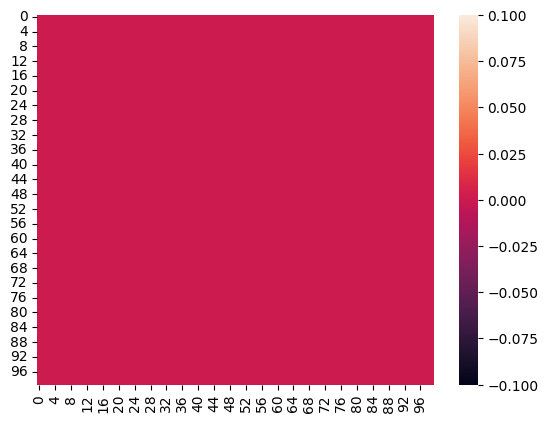

In [106]:
sns.heatmap(ld_matrix)